In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from store import *

In [2]:
store = Store(os.getenv('localappdata') + r'\Kaspad\kaspa-mainnet\datadir2')
store.load_blocks()

Pruning point:  ce5e2edd1d0278215a093ee54c9ac4e8ba402533fefc4fa1d27c40bf72f9f3e9
Loaded 40000 blocks
Loaded 80000 blocks
Loaded 120000 blocks
Loaded 160000 blocks
Loaded 200000 blocks
Loaded 240000 blocks
Loaded 280000 blocks
Loaded 320000 blocks
Loaded 360000 blocks
Overall number of headers:  371314


In [3]:
header_fields = ['timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty']
block_fields = ['pubkey_script']
count_fields = ['num_parents', 'num_children', 'num_blues', 'num_reds']
frames = store.load_data(header_fields=header_fields, block_fields=block_fields, count_fields=count_fields)

Loaded data of 10000 blocks
Loaded data of 20000 blocks
Loaded data of 30000 blocks
Loaded data of 40000 blocks
Loaded data of 50000 blocks
Loaded data of 60000 blocks
Loaded data of 70000 blocks
Loaded data of 80000 blocks
Loaded data of 90000 blocks
Loaded data of 100000 blocks
Loaded data of 110000 blocks
Loaded data of 120000 blocks
Loaded data of 130000 blocks
Loaded data of 140000 blocks
Loaded data of 150000 blocks
Loaded data of 160000 blocks
Loaded data of 170000 blocks
Loaded data of 180000 blocks
Loaded data of 190000 blocks
Loaded data of 200000 blocks
Loaded data of 210000 blocks
Loaded data of 220000 blocks
Loaded data of 230000 blocks
Loaded data of 240000 blocks
Loaded data of 250000 blocks
Loaded data of 260000 blocks
Loaded data of 270000 blocks
Loaded data of 280000 blocks
Loaded data of 290000 blocks
Loaded data of 300000 blocks
Loaded data of 310000 blocks
Loaded data of 320000 blocks
Loaded data of 330000 blocks
Loaded data of 340000 blocks
Loaded data of 350000 b

In [4]:
frames.keys()

dict_keys(['hash', 'timeInMilliseconds', 'blueScore', 'blueWork', 'daaScore', 'difficulty', 'pubkey_script', 'num_parents', 'num_children', 'num_blues', 'num_reds'])

In [5]:
df = pd.DataFrame(frames).set_index('hash')

In [6]:
pp_time = store.get_header_data(store.pruning_point()).timeInMilliseconds
pp_time

1642507533880

## Number of child blocks

This is the first sighn somthing is wrong -- A high number of child blocks indicates that some miners are stuck mining on some point in history, and are not even succeding to update their node about the blocks they have found. 

In the figure below we see that at some point last night many blocks were mined over the same points in DAG history (up to 200 blocks over each point).  

This event seems to take place over ~5 hours (It is also possible that the miner is stuck with old timestamps, but is actually mining these blocks since that point until now)  

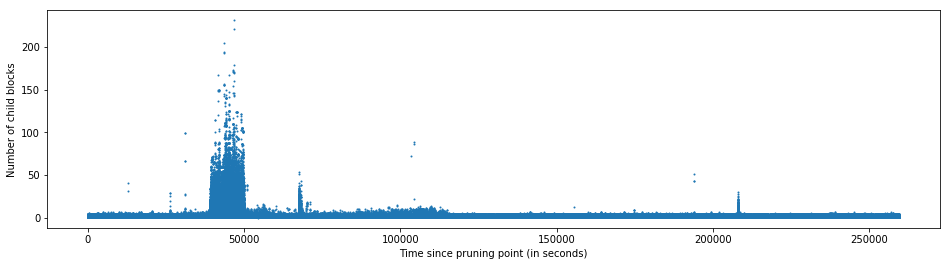

In [7]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_children'], s=1)
plt.ylabel('Number of child blocks')
plt.xlabel('Time since pruning point (in seconds)')
plt.show()

## Number of merged reds 

Here we already see an indication of a netsplit. Not only that (or those) miner is stuck, but it also did not publish his blocks for a few hours. It seems like all or most of these blocks were published over the following 5 hours. 

Since the network merges them as red blocks in bulks of max 180, we see this in the following figure.

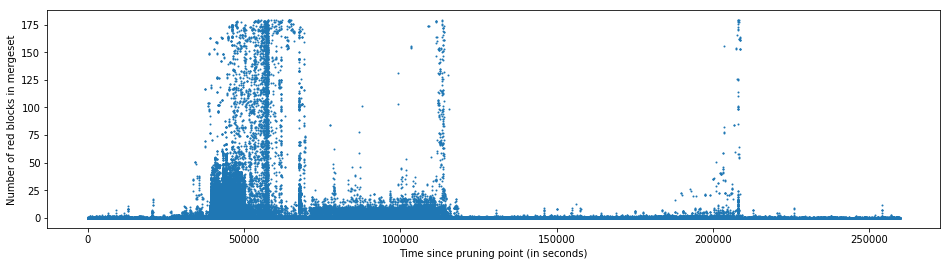

In [8]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_reds'], s=1)
plt.ylabel('Number of red blocks in mergeset')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\reds.png')
plt.show()

## Global hashrate waves

It seems like the above huge merge events envolved performance issues in all nodes in the network (many blocks published at once with weird DAG structure which challenges current kaspa imp) -- this in turn leads to the node being unsynced for short periods -- which reduces the hashrate of each node -- hence leading to a global effect.  

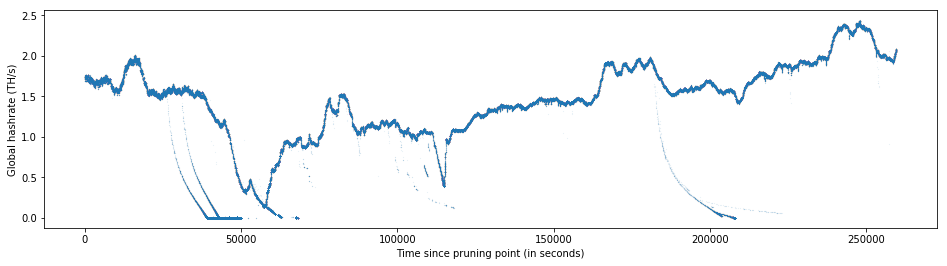

In [28]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['difficulty']*2/1000000000000, s=0.001)
plt.ylabel('Global hashrate (TH/s)')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\ghr.png')
plt.show()

## Blue work

This indicates that the side-DAG was not accumulating its work in a proper *k*-cluster (`k=18` in our system), but rather creating "antichains" (note the flat lines below)

This indicates this was probably not a deliberate attack, or if it was, it was attacking performance but not attaempting a reorg. 

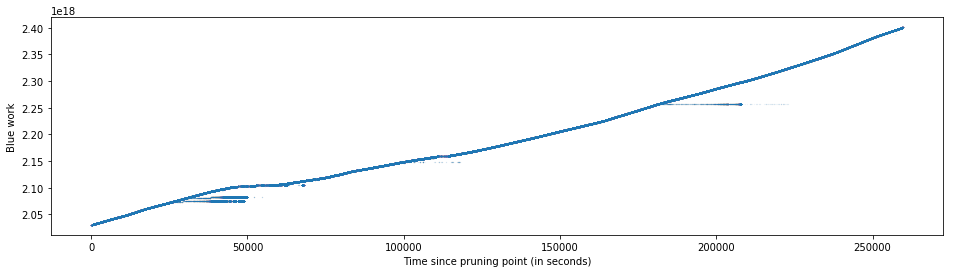

In [10]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueWork'], s=0.0005)
plt.ylabel('Blue work')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\bw.png')
plt.show()

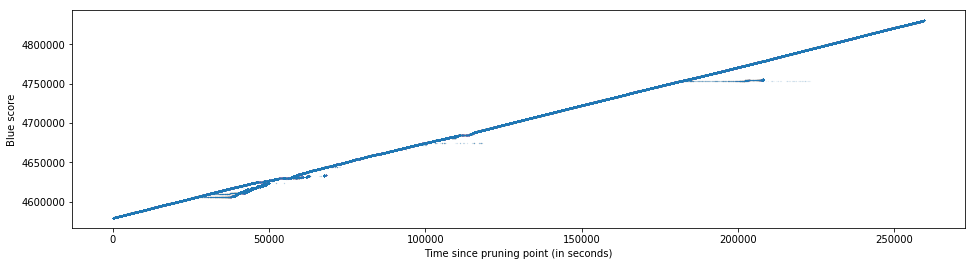

In [11]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueScore'], s=0.0005)
plt.ylabel('Blue score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\bw.png')
plt.show()

In [12]:
df_sortedby_time = df.sort_values(by='timeInMilliseconds')

## Block count

During this event, however, both disonnected parts mine at a rate of 1 block per second, so block rate was doubled for a few hours as seen below.

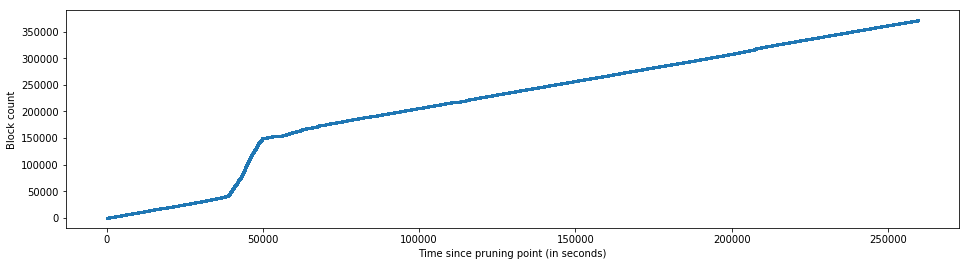

In [13]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, np.arange(len(df_sortedby_time['daaScore'])), s=1)
plt.ylabel('Block count')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\count.png')
plt.show()

## DAA score

Despite the double amount of blocks (which does effect processing time), DAA score which controls the emission rate of KAS, was uneffected since by design it considres rewards only from one side of the split.

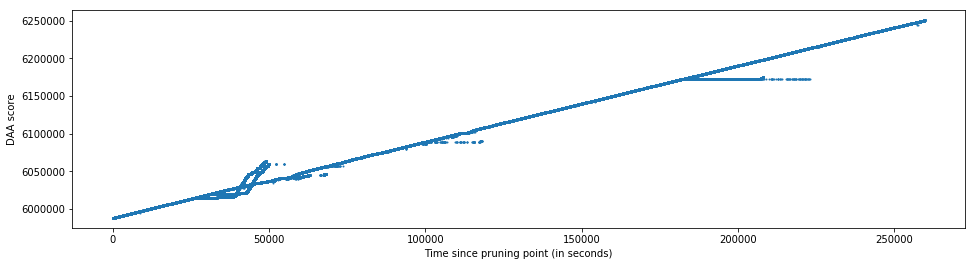

In [14]:
plt.figure(figsize=(16, 4))
plt.scatter((df_sortedby_time['timeInMilliseconds'] - pp_time)/1000, df_sortedby_time['daaScore'], s=1)
plt.ylabel('DAA score')
plt.xlabel('Time since pruning point (in seconds)')
plt.savefig(r'images\daa.png')
plt.show()

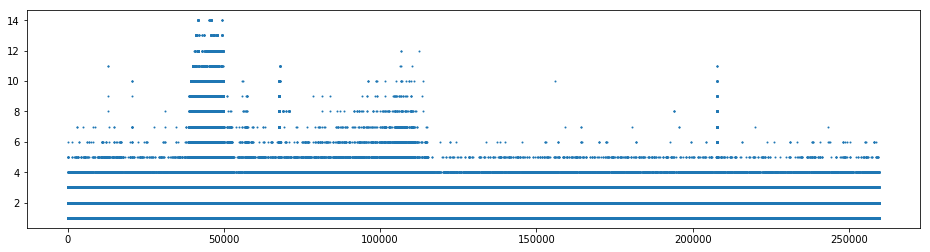

In [15]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_blues'], s=1)
plt.show()

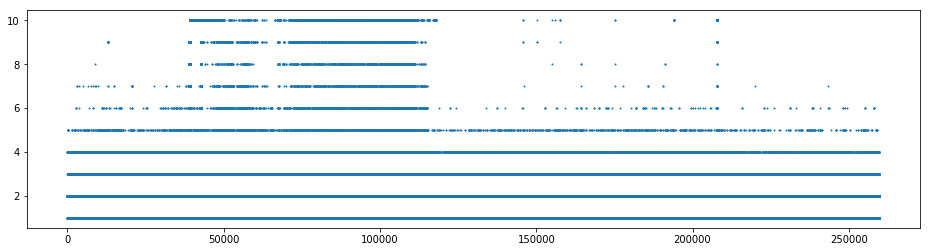

In [16]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['num_parents'], s=1)
plt.show()

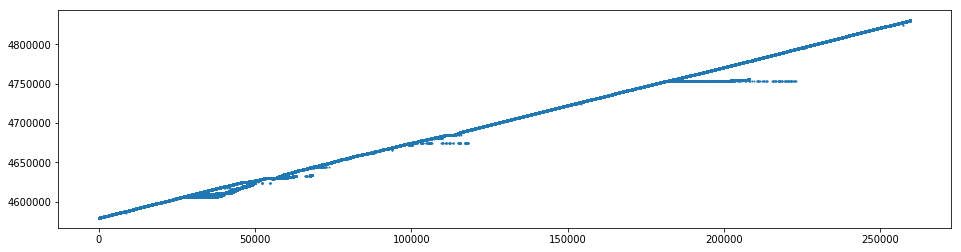

In [17]:
plt.figure(figsize=(16, 4))
plt.scatter((df['timeInMilliseconds'] - pp_time)/1000, df['blueScore'], s=1)
plt.show()

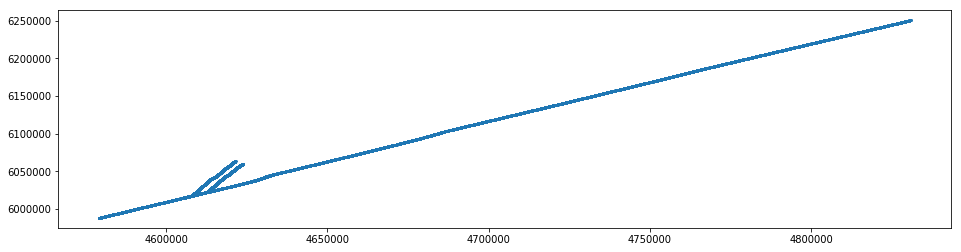

In [18]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueScore'], df['daaScore'], s=1)
plt.show()

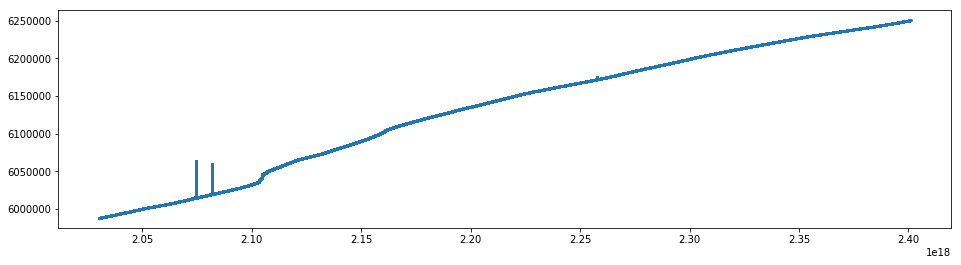

In [19]:
plt.figure(figsize=(16, 4))
plt.scatter(df['blueWork'], df['daaScore'], s=1)
plt.show()

In [20]:
df_groupedby_miner = df.groupby('pubkey_script')

In [21]:
len(df_groupedby_miner)

603

## Explore mining addresses of red blocks

Below we explore the mining addresses of those stalled red blocks and observe they mostly come from ~8 mining addresses.

In [22]:
virtual_reds = store.get_virtual_reds(threshold=0, time_distance=3600*1000)
len(virtual_reds)

95217

In [23]:
miner_scripts = {}
for r in virtual_reds:
    if r in df.index:
        key = df.loc[r]['pubkey_script']
        if key in miner_scripts:
            miner_scripts[key] += 1
        else:
            miner_scripts[key] = 1
len(miner_scripts)

63

In [24]:
miners_sortedby_reds = sorted(miner_scripts.items(), key=lambda kvp: kvp[1], reverse=True)

**Miner public-key scripts with large amounts of red blocks:**

In [25]:
for kvp in miners_sortedby_reds:
    if kvp[1] < 500:
        break
    print(kvp[0].hex(), '\t', kvp[1])

aa20af7f68183a9c26f1901b4a6bd44dc94170bcd838ffe0715b67d59aab8c6817ea87 	 22881
20b313ab26bf182939e295e9715cda8331b3d87d70312bfbf71fb6b7d0927a5000ac 	 17605
20993d2795bb0ad8d0ef7fcfb736a229da8ac941336b3ebefcbce44749bbe5d44bac 	 14202
20efbb5e841753f18a78329f73818c0dab0b206201c84df52b30eb388dc9f8975fac 	 13718
2038e676cdf23f8865743dc051a96a72dfb63f60cd6fcaf4a66801cd928e629c99ac 	 8771
20901438e65f87c752b10c051190e0c6672a8f9edc0e82516b049015d1bf453b3fac 	 5409
20f7c7f2c388f7e98332143df363bf33db799d05472dfb497964bb8c0141da8574ac 	 5288
20b96eaf506c4f0a3c9e243e4dfb4a337356e1bc40908abed4e3cc7ffb536e5da4ac 	 3735
2064156a28f0d5c83f6fca68f8e80fdf431db45240e093acfb3ae1c63608e3000fac 	 2383
20bc9d30ce088fd4fbabc2a7d8aaec9feaa597cddfe24c7804141f3a763a4d9703ac 	 607


**Mining addresses with large amounts of red blocks:**

`
Mining address											          |   # of stalled red blocks
-------------------------------------------------------------------- |--------------------------
kaspa:qze382exhuvzjw0zjh5hzhx6svcm8krawqcjh7lhr7mt05yj0fgqqrwne4unv  |   17605
kaspa:qzvn6fu4hv9d35800l8mwd4z98dg4j2pxd4na0huhnjywjdmuh2yksd5e4agx  |   14202
kaspa:qrhmkh5yzaflrzncx20h8qvvpk4skgrzq8yymaftxr4n3rwflzt47vzfrdrtk  |   13718
kaspa:qquwvakd7glcset58hq9r2t2wt0mv0mqe4hu4a9xdqqumy5wv2wfjdmnp3al3  |   8771
kaspa:qzgpgw8xt7ruw543psz3ry8qcenj4ru7ms8gy5ttqjgpt5dlg5an7yecvdafk  |   5409
kaspa:qrmu0ukr3rm7nqejzs7lxcalx0dhn8g9guklkjtevjaccq2pm2zhg929k9gg2  |   5288
kaspa:qzukat6sd38s50y7yslym762xde4dcdugzgg40k5u0x8l76ndew6g0eeu2t8e  |   3735
kaspa:qpjp263g7r2us0m0ef5036q0map3mdzjgrsf8t8m8tsuvdsguvqq7nzj3ju6j  |   2383
`

In [29]:
# store.close()